# Paper_Classifier_1

### Label이 기타(2)인 데이터를 떼고 학습시킨 모델

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
# 의사결정나무
from sklearn.tree import DecisionTreeClassifier 
# 랜덤포레스트, 그래디언트 부스팅
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier,HistGradientBoostingClassifier
from xgboost import XGBClassifier
# 그리드 서치
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,recall_score
import time

# 데이터 불러오기

In [2]:
# filepath 입력
filepath = "/home/piai/test/Big_Data_분석_기초/제지공장 프로젝트/data/B2_제지/train_data_1.csv"
# 레이블 칼럼명 입력
label_col= "result"

In [3]:
df = pd.read_csv(filepath,index_col="Unnamed: 0")
df[label_col].value_counts()
df.columns

Index(['TAG_001', 'TAG_002', 'TAG_003', 'TAG_004', 'TAG_005', 'TAG_006',
       'TAG_007', 'TAG_008', 'TAG_009', 'TAG_010',
       ...
       'TAG_188', 'TAG_189', 'TAG_190', 'TAG_191', 'TAG_192', 'TAG_193',
       'TAG_194', 'TAG_195', 'TAG_196', 'result'],
      dtype='object', length=197)

In [4]:
col_num = "003 010 019 036 039 051 055 061 081 082 083 091 092 093 094 095 096 097 098 117 118 121 124 125 126 173 176 196".split(' ')

In [5]:
col_num = ["TAG_{}".format(num) if len(col_num[0])==3 else num for num in col_num ]

In [6]:
df_drop = df.drop([*col_num],axis=1)

In [7]:
df_droped = df_drop[~(df_drop[label_col]==2)]
df_droped[label_col].value_counts()

0    68110
1     7413
Name: result, dtype: int64

In [8]:
df_x = df_droped.drop(label_col,axis=1,inplace=False)
df_y = df_droped[label_col]

In [9]:
df_train_x,df_test_x, df_train_y, df_test_y = train_test_split(df_x,df_y,test_size=0.3,random_state=1234)

In [10]:
df_test_y.value_counts()

0    20461
1     2196
Name: result, dtype: int64

In [11]:
df_train_y.value_counts()

0    47649
1     5217
Name: result, dtype: int64

## HGB - Nan값이 들어와도 학습하는 모델

In [12]:
para_leaf=[n_leaf * 1 for n_leaf in range(1,21)]
para_split=[n_split * 2 for n_split in range(1,21)]
para_depth=[depth for depth in range(2,11)]
para_n_tree=[n_tree*1 for n_tree in range(1,11)]
para_lr=[n_lr *0.1 for n_lr in range(1,11)]

In [13]:
start = time.time()
estimator = HistGradientBoostingClassifier(random_state=1234)
param_rand={
            "max_depth":para_depth,
#             "min_samples_split":para_split,
            "min_samples_leaf":para_leaf,
#             "n_estimators":para_n_tree,
            "learning_rate":para_lr
           }
rand_hgb = RandomizedSearchCV(estimator, param_rand, n_iter = 5, cv = 3, scoring="f1", n_jobs=-1,verbose=0)
rand_hgb.fit(df_train_x,df_train_y)

RandomizedSearchCV(cv=3,
                   estimator=HistGradientBoostingClassifier(random_state=1234),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2,
                                                          0.30000000000000004,
                                                          0.4, 0.5,
                                                          0.6000000000000001,
                                                          0.7000000000000001,
                                                          0.8, 0.9, 1.0],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20]},
                   scoring='f1')

In [14]:
print("소요시간 :", time.time() - start)

소요시간 : 11.831423282623291


In [15]:
best_hgb = rand_hgb.best_estimator_
best_hgb

HistGradientBoostingClassifier(learning_rate=0.30000000000000004, max_depth=8,
                               min_samples_leaf=19, random_state=1234)

In [16]:
hgb_result = best_hgb.fit(df_train_x,df_train_y)
print("Score on training set  {:.3f}".format(best_hgb.score(df_train_x, df_train_y)))
print("Score on testing set  {:.3f}".format(best_hgb.score(df_test_x, df_test_y)))

Score on training set  0.999
Score on testing set  0.994


## XGB - use_missing=False가 Nan값을 무시하고 학습하라는 파라미터

In [17]:
start = time.time()

In [18]:
estimator = XGBClassifier(random_state=1234,use_missing=False)
param_rand={
            "learning_rate":para_lr,    
            "max_depth":para_depth,
            "n_estimators":para_n_tree
           }
rand_xgb = RandomizedSearchCV(estimator, param_rand, n_iter = 5, cv = 10, scoring="f1", n_jobs=-1,verbose=0)
rand_xgb.fit(df_train_x,df_train_y)

[00:32:43] WARNING: ../src/learner.cc:627: 
Parameters: { "use_missing" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=1234,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2,
                                                          0.30000000000000004,
                                                          0.4, 0.5,
                                                          0.6000000000000001,
                                                          0.7000000000000001,
                                                          0.8, 0.9, 1.0],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10]},
                   scoring='f1')

In [19]:
print("소요시간 :", time.time() - start)

소요시간 : 175.96803951263428


In [20]:
best_xgb = rand_xgb.best_estimator_
best_xgb

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.7000000000000001, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=10, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=8, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1234, reg_alpha=0, reg_lambda=1, ...)

In [21]:
xgb_result = best_xgb.fit(df_train_x,df_train_y)
print("Score on training set  {:.3f}".format(best_xgb.score(df_train_x, df_train_y)))
print("Score on testing set  {:.3f}".format(best_xgb.score(df_test_x, df_test_y)))

[00:32:51] WARNING: ../src/learner.cc:627: 
Parameters: { "use_missing" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Score on training set  0.998
Score on testing set  0.988


# 변수 중요도

In [22]:
# print(best_hgb.feature_importances_.round(3))
print(best_xgb.feature_importances_.round(3))

[0.001 0.002 0.003 0.003 0.003 0.003 0.    0.    0.    0.001 0.002 0.002
 0.002 0.001 0.003 0.004 0.    0.    0.    0.    0.    0.    0.    0.
 0.001 0.    0.001 0.001 0.001 0.002 0.001 0.001 0.003 0.001 0.005 0.001
 0.004 0.003 0.002 0.004 0.002 0.009 0.012 0.    0.003 0.002 0.    0.001
 0.001 0.001 0.    0.002 0.006 0.001 0.001 0.002 0.001 0.003 0.001 0.002
 0.004 0.002 0.003 0.002 0.002 0.004 0.002 0.005 0.006 0.006 0.002 0.002
 0.002 0.001 0.002 0.004 0.004 0.002 0.002 0.001 0.002 0.003 0.002 0.002
 0.002 0.447 0.002 0.002 0.003 0.003 0.006 0.    0.002 0.002 0.015 0.001
 0.004 0.001 0.001 0.    0.    0.007 0.003 0.004 0.002 0.001 0.014 0.002
 0.001 0.006 0.002 0.002 0.005 0.002 0.001 0.003 0.002 0.008 0.002 0.002
 0.001 0.001 0.001 0.008 0.005 0.005 0.002 0.005 0.004 0.003 0.003 0.002
 0.01  0.002 0.003 0.003 0.004 0.005 0.002 0.003 0.001 0.001 0.01  0.001
 0.003 0.06  0.011 0.004 0.006 0.002 0.002 0.    0.006 0.003 0.003 0.007
 0.016 0.003 0.007 0.001 0.019 0.002 0.002 0.001 0.002

In [33]:
# 변수중요도 상위 몇 개?
top_importance = 5

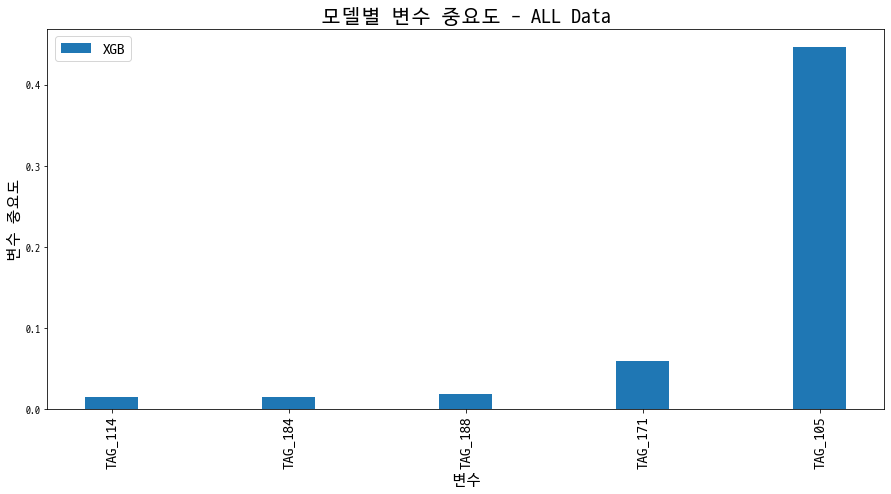

In [34]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
# df_importance["DT_Importance"] = best_dt.feature_importances_
# df_importance["RF_Importance"] = best_rf.feature_importances_
# df_importance["HGB_Importance"] = best_hgb.feature_importances_
df_importance["XGB_Importance"] = best_xgb.feature_importances_
df_importance.sort_values("XGB_Importance", ascending=True, inplace=True)
# coordinates_dt = [i for i in range(len(df_importance))]
# coordinates_hgb = [i+0.3 for i in range(len(df_importance))]
coordinates_xgb = [i+0.6 for i in range(len(df_importance))]
# coordinates_rf = [i for i in range(len(df_importance))]
plt.figure(figsize=(15,7))
# plt.bar(x=coordinates_dt, height=df_importance['DT_Importance'],width=0.3,label="DT")
# plt.bar(x=coordinates_rf, height=df_importance['RF_Importance'],width=0.3,label="RF")
# plt.bar(x=coordinates_hgb, height=df_importance['HGB_Importance'],width=0.3,label="GB")
plt.bar(x=coordinates_xgb[-top_importance:], height=df_importance['XGB_Importance'][-top_importance:],width=0.3,label="XGB")
plt.legend(fontsize=15)
plt.title("모델별 변수 중요도 - ALL Data",fontsize=20)
plt.xticks(coordinates_xgb[-top_importance:],df_importance['Feature'][-top_importance:],rotation=90,fontsize=15)
plt.ylabel("변수 중요도",fontsize=15)
plt.xlabel("변수",fontsize=15)
plt.show()

## 모델 성능

### HGB

In [35]:
y_pred = hgb_result.predict(df_test_x)
print("Confusion Matrix:\n{}\n".format(confusion_matrix(df_test_y,y_pred)))

Confusion Matrix:
[[20429    32]
 [   96  2100]]



In [36]:
f1_score(df_test_y,y_pred)

0.9704251386321626

In [37]:
accuracy_score(df_test_y,y_pred)

0.9943505318444631

In [38]:
recall_score(df_test_y,y_pred)

0.9562841530054644

### XGB

In [39]:
y_pred = xgb_result.predict(df_test_x)
print("Confusion Matrix:\n{}\n".format(confusion_matrix(df_test_y,y_pred)))

Confusion Matrix:
[[20383    78]
 [  201  1995]]



In [40]:
f1_score(df_test_y,y_pred)

0.9346451159522136

In [41]:
accuracy_score(df_test_y,y_pred)

0.9876859248797282

In [42]:
recall_score(df_test_y,y_pred)

0.9084699453551912